## Ch.13 CNN Part 4
### Improving Traing Stability

In [31]:
from fastai.vision.all import *
import torch
import torch.nn as nn
import torch.nn.functional as F



In [11]:
path = untar_data(URLs.MNIST)

In [12]:
path.ls()

(#2) [Path('/Users/hwangsia/.fastai/data/mnist_png/training'),Path('/Users/hwangsia/.fastai/data/mnist_png/testing')]

In [24]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW),CategoryBlock), # PILImage --> RGB 3channels / PILImageBW --> Grayscale 1channel
        get_items=get_image_files,
        splitter=GrandparentSplitter("training", "testing"),
        get_y=parent_label, 
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

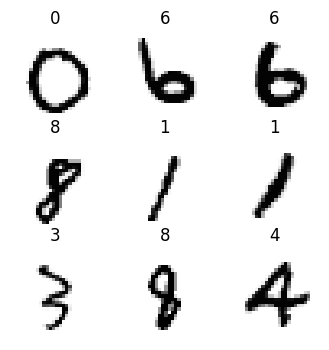

In [25]:
dls = get_dls()
# it's always a good idea to look at your data before using it
dls.show_batch(max_n=9, figsize = (4,4))

In [35]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni,nf,stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [36]:
def simple_cnn(): # for a higher compression ratio, set ks = 5
    return sequential(
        conv(1,8,ks=5), #14*14   
        conv(8,16),     #7*7
        conv(16,32),    #4*4
        conv(32,64),    #2*2
        conv(64,10, act=False), #1*1
        Flatten(),  # (B,10,1,1) -> (B,10)
    )

## Core Idea: Compression Ratio in CNNs

When designing convolutional layers, the **compression ratio** refers to how much the number of outputs is reduced compared to the number of inputs used in each kernel operation.

- **If the output size is almost the same as the input size**, the network is not forced to compress information, which means it may learn fewer useful features.
- **If the output size is significantly smaller than the input size**, the network must compress information, pushing it to extract the most important and discriminative features.

### Example:
- **3×3 kernel** → 9 input pixels per location.
  - 4 output channels → 9 inputs → 4 outputs → Good compression.
  - 8 output channels → 9 inputs → 8 outputs → Almost no compression.

### Why it matters:
A high compression ratio forces the network to **encode only the most valuable features** from the inputs, improving generalization and efficiency.

In [29]:
from fastai.callback.hook import *

In [39]:
def train_model(epochs=1, lr=0.06):
    """
    Learner 객체를 생성하고 지정된 epoch 동안 학습시킨 뒤 반환합니다.
    
    Args:
        epochs (int): 학습 반복 횟수
        lr (float): 학습률
    
    Returns:
        Learner: 학습이 완료된 Learner 객체
    """
    # Learner 객체 생성 (모델: simple_cnn)
    learn = Learner(
        dls,                       # train/valid data
        simple_cnn(),              # CNN model defined earlier
        loss_func=F.cross_entropy, 
        metrics=accuracy,        
        cbs=ActivationStats(with_hist=True)  # activation histogram callback 
    )
    
    # fastai Learner's fit() method
    learn.fit(epochs, lr)
    
    return learn
learn = train_model() # This did not train at all. Why?

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.306702,2.309290,0.113500,00:36


 ### Activation Stats Interpretation

#### 1. Mean
- **Definition:** Average activation value for the layer.
- **Goal:** Close to **0** throughout training.
- **Why:** Balanced positive/negative activations → stable gradients.
- **Rule of Thumb:**
  - ✅ Good: between **-0.1 and 0.1** (small fluctuations are fine)
  - ⚠ Bad: consistently > |0.5| → check weight initialization or normalization.

---

#### 2. Std (Standard Deviation)
- **Definition:** Spread (magnitude) of activation values.
- **Goal:** Around **1** for most layers.
- **Why:** 
  - Too small (< 0.1) → vanishing activations → poor signal flow.
  - Too large (> 3–4) → exploding activations → unstable learning.
- **Rule of Thumb:**
  - ✅ Good: 0.5–2 (depends on activation function)
  - ⚠ Bad: very flat or sudden spikes → tune LR, initialization, or normalization.

---

#### 3. % Near Zero
- **Definition:** Percentage of activations very close to zero.
- **Goal:** Moderate sparsity.
- **Why:** 
  - High % → sparsity → better generalization.
  - Extremely high (>90%) → many dead neurons.
  - Very low (<10%) → over-activation → risk of overfitting.
- **Rule of Thumb:**
  - ✅ Good: 30%–70%
  - ⚠ Bad: >90% or <10% → adjust activation function, initialization, or LR.

---

### Quick Diagnosis Table

| Symptom                  | Likely Cause                       | Possible Fixes                            |
|--------------------------|-------------------------------------|--------------------------------------------|
| Mean far from 0          | Weight init, missing normalization | BatchNorm, Xavier/He init                  |
| Std very small           | Vanishing activations               | Increase LR slightly, adjust initialization|
| Std very large           | Exploding activations               | Reduce LR, gradient clipping               |
| % Near Zero too high     | Dead neurons                        | Lower LR, change activation                |
| % Near Zero too low      | Over-activation                     | Add regularization, reduce LR              |

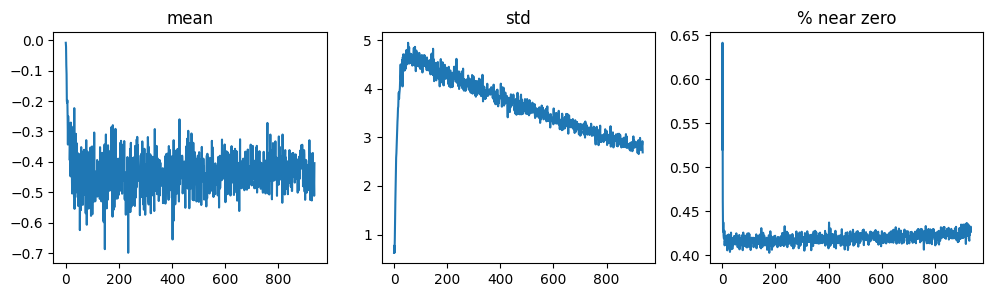

In [40]:
learn.activation_stats.plot_layer_stats(0)

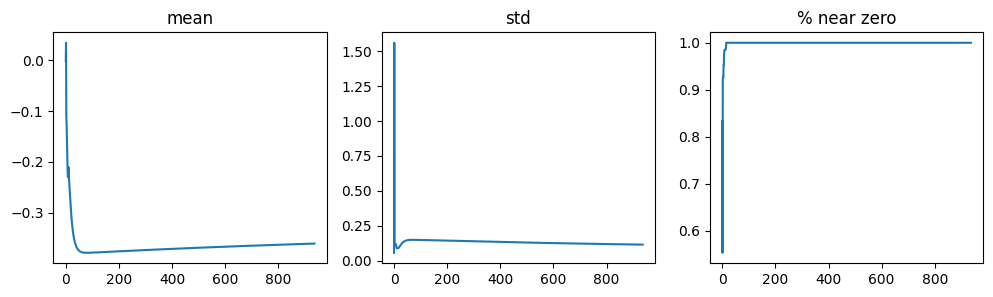

In [41]:
learn.activation_stats.plot_layer_stats(-2)

#### Why This Indicates Poor Training

- **First Layer (idx = 0)**:
  - Mean and std are relatively stable.
  - `% near zero` around ~0.45–0.55, which is normal for ReLU.
  - This layer is functioning normally.

- **Penultimate Layer (idx = -2)**:
  - Mean quickly flattens near a constant value.
  - Std collapses close to zero → activations have almost no variation.
  - `% near zero` spikes to ~1.0 → nearly all outputs are zero.
  - This means the layer produces no meaningful signal for the next layer, and gradients vanish, preventing learning in deeper layers.

**Conclusion:**  
The network suffers from severe activation collapse in deeper layers, causing vanishing gradients and halting learning. This is why training does not progress.

## Increase Batch Size

#### Batch Size vs. Training Dynamics

**Larger Batch Size**
- **Pros**: More stable gradients (less variance due to more samples per update)
- **Cons**: Fewer weight updates per epoch → slower learning opportunities

**Smaller Batch Size**
- **Pros**: More weight updates per epoch → potentially faster learning
- **Cons**: Noisier gradients (higher variance due to fewer samples per update)

**Key Trade-off**:  
Stable gradients vs. frequent updates — finding the right balance is essential for efficient training.

In [43]:
dls = get_dls(512) 
# Increased the batch size from 64 to 512
# Larger batch size --> stable gradients but fewer updates

learn = train_model()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.305775,2.301802,0.113500,00:26


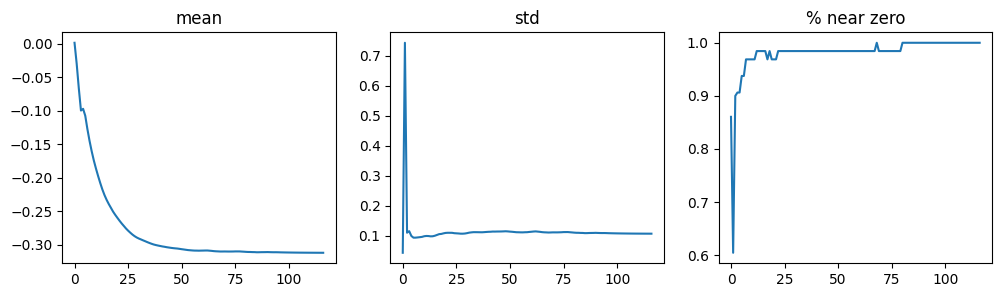

In [44]:
learn.activation_stats.plot_layer_stats(-2)
# Again, we've got most of our activations near zero
# The issue is likely not caused by batch size.
# More fundamental training stability problems may be involved,
# such as weight initialization, learning rate, activation function,
# or network architecture.

## 1cycle Learning Rate & Momentum Strategy

### Learning Rate Phases
1. **Warmup**  
   - Start with a **low learning rate** to stabilize training and avoid divergence at the beginning.  

2. **Explore**  
   - Gradually **increase the learning rate** to a much higher value.  
   - Encourages the optimizer to explore **wider, flatter minima** instead of sharp local minima.  
   - Leads to faster convergence and reduces overfitting.  

3. **Anneal**  
   - Gradually **decrease the learning rate** to a very small value.  
   - Allows **fine-tuning** of weights and convergence to the best part of the minimum.  

---

### Cyclical Momentum
- Momentum changes **inversely** to the learning rate:
  - **High LR → Low Momentum**
  - **Low LR → High Momentum**

**Rationale**:  
- High LR: Larger parameter updates → reduce momentum to avoid overshooting.  
- Low LR: Smaller parameter updates → increase momentum to maintain optimization speed.  

---

### Why Adjust LR in Phases?
- **Warmup**: Prevents instability and exploding loss at the start.  
- **High LR phase**: Helps escape sharp, narrow minima and explore the parameter space more broadly.  
- **Annealing phase**: Helps settle into a **smooth, generalizable region** of the loss surface for better performance on unseen data.  


In [46]:
def train_model(epochs=1, lr=0.06):
    learn = Learner(dls, 
                    simple_cnn(),
                    loss_func=F.cross_entropy,
                    metrics=accuracy,
                    cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr) 
     # Unlike fit(), fit_one_cycle() method adjusts both learning rate 
     # and momentum (inversely) during training, following 
     # the 1cycle policy.
    return learn

learn = train_model() # We're finally making some progress

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.207503,0.080130,0.974200,00:26


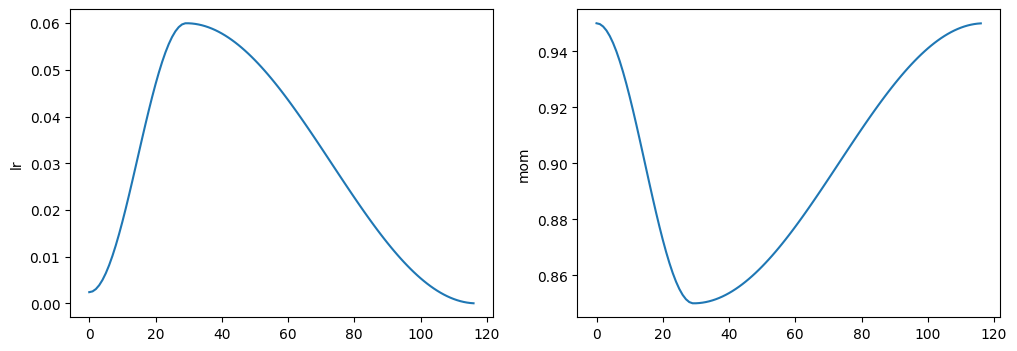

In [49]:
learn.recorder.plot_sched() # we can view the lr and momentum throughput training 

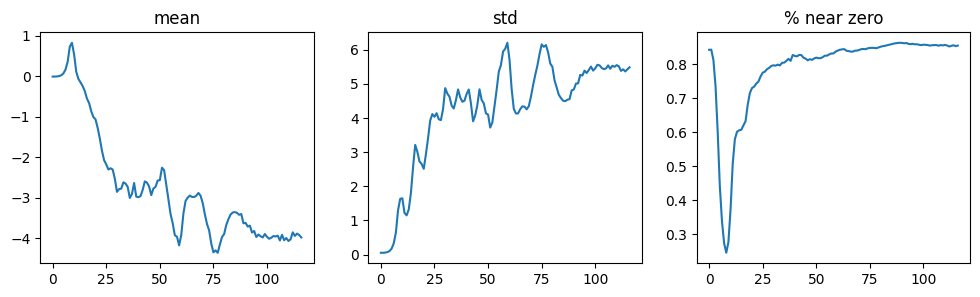

In [50]:
learn.activation_stats.plot_layer_stats(-2) 
# The percentage of nonzero weights is getting 
# much better although it's still quite high

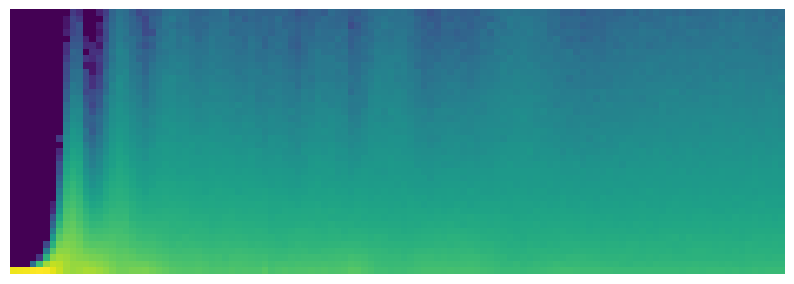

In [51]:
learn.activation_stats.color_dim(-2)

## Batch Normalization

### 1. Problem: Internal Covariate Shift
- **Definition:** During training, the distribution of each layer’s inputs changes as the parameters of previous layers are updated.
- **Impact:**
  - Slows down training because we must use **lower learning rates** to maintain stability.
  - Requires **careful parameter initialization** to avoid divergence.
- **Reason:** Each layer depends on the outputs of the previous one. When those outputs shift in mean/variance, the current layer must constantly readjust.

---

### 2. Batch Normalization — The Solution
- **Goal:** Keep the input distribution to each layer more stable during training.
- **How it works:**
  1. For each layer, compute the **mean** and **standard deviation** of activations for the current **mini-batch**.
  2. Normalize activations:
     $
     \hat{x} = \frac{x - \mu_{\text{batch}}}{\sigma_{\text{batch}} + \epsilon}
     $
  3. Apply learnable parameters:
     $
     y = \gamma \hat{x} + \beta
     $
     - **γ (gamma):** scaling factor (learned during training)
     - **β (beta):** shift factor (learned during training)
  4. This allows any mean/variance in outputs while keeping training stable.

---

### 3. Training vs Validation
- **Training mode:**  
  - Compute **mean** and **std** for each feature/channel **from the current mini-batch**.  
  - Normalize using those batch statistics.
- **Validation mode:**  
  - Use **running mean** and **running std** (collected during training) for normalization.

---

### 4. Benefits
- Enables **much higher learning rates** without instability.
- Reduces sensitivity to initialization.
- Acts as a form of regularization (can reduce overfitting).
- Can significantly speed up convergence (up to ~5× faster in original paper).


In [53]:
# add a batchnorm layer to conv
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni,nf,stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf)) #Conv --> Batchnorm
    if act: layers.append(nn.ReLU()) #Conv --> Batchnorm (--> ReLU)
    return nn.Sequential(*layers) 

learn = train_model()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.138263,0.062047,0.984400,00:28


### nn.BatchNorm2d(nf)
- **목적**: Conv2D 출력 채널별로 평균 0, 표준편차 1로 정규화해 학습 안정화.
- **nf**: Conv2D의 출력 채널 수.
- **동작**:
  1. 한 배치 내에서 각 채널별 평균과 표준편차 계산.
  2. `(출력 - 평균) / 표준편차`로 정규화.
  3. 학습 가능한 `γ`(scale), `β`(shift)로 다시 변환.
- **효과**:
  - Internal covariate shift 감소.
  - 학습률을 더 높게 설정 가능.
  - 수렴 속도 및 정확도 개선.

In [54]:
# increase the lr (batchnorm enables us to train at much higher lrs)

learn = train_model(5, lr=0.1)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/fastai/callback/core.py:71: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.192796,0.085673,0.971800,00:26
1,0.078739,0.061082,0.981600,00:26
2,0.053984,0.047775,0.983900,00:25
3,0.033525,0.029857,0.990700,00:25
4,0.017519,0.023191,0.992100,00:25
